# Homework 1: Soccer Analytics, and the European League System
Amanda Kuznecov (anr431)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson
import random

In [5]:
import os
os.chdir('/Users/amandarella/Documents/NYU/DS-GA_3001_Sports_Data/Lectures/Lecture_1')

In [6]:
#read in data with certain columns
df = pd.read_csv('soccer17.csv', index_col = False, 
                 parse_dates = ['Date'])

#include Game ID to differentiate games for future use
df.loc[:,'Game_ID'] = df.index

#rename columns
df = df.rename({'HomeTeam': 'Team_Home','AwayTeam': 'Team_Away',
                'FTHG': 'FTG_Home','FTAG': 'FTG_Away',
                'HTHG': 'HTG_Home','HTAG': 'HTG_Away'}, axis=1)

## Question 1: Goal Differentials

### Part 1a

In [7]:
df_gd = df.copy()
#calculate goal differentials for home and away teams of each match
df_gd.loc[:,'GD_Home'] = df_gd.loc[:,'FTG_Home']-df_gd.loc[:,'FTG_Away']
df_gd.loc[:,'GD_Away'] = df_gd.loc[:,'FTG_Away']-df_gd.loc[:,'FTG_Home']

In [8]:
#only need goal differential columns; drop others
df_gd= df_gd.drop(columns = ['FTG_Home','FTG_Away','HTG_Home',
                             'HTG_Away','pH','pD','pA'], axis=1)

In [9]:
#pivot table to get all goal differentials in one column
df_long = pd.wide_to_long(df_gd, ['Team','GD'], i = ['Game_ID'], 
                          j = 'isHome', sep = '_', suffix = r'\w+')

#reindex to get rid of multi-index
df_long = df_long.reset_index().sort_values(['Date','Game_ID']) 

#remove columns not needed
df_long = df_long.drop(columns = ['isHome'])

In [10]:
#create function for new column noting whether team won or loss
def result(df):
    if df.GD == 0:
        val = 'Draw'
    elif df.GD > 0:
        val = 'Win'
    else:
        val = 'Loss'
    return val

In [11]:
#apply function to table
df_long.loc[:,'Result'] = df_long.apply(result,axis=1)

In [12]:
#create copy with only English Premier League data for 2017 season
df_epl = df_long.loc[(df_long.Div=='EPL') & (df_long.Y == 17)].copy()

In [13]:
#group data by team names
group_team = df_epl.groupby('Team')

In [14]:
#create summary table
epl_summary = group_team.agg(
    GD_avg = pd.NamedAgg(column = 'GD', aggfunc = 'mean'),
    Num_games = pd.NamedAgg(column = 'Game_ID', aggfunc = 'count'),
    Wins = pd.NamedAgg(column = 'Result', 
                       aggfunc=lambda x: (x == 'Win').sum()),
    Draws = pd.NamedAgg(column = 'Result', 
                        aggfunc=lambda x: (x == 'Draw').sum()),
    Losses = pd.NamedAgg(column = 'Result', 
                         aggfunc=lambda x: (x == 'Loss').sum()),
)

In [15]:
#create copy of dataframe
epl_gd = epl_summary.copy()

#create new ranking column by goal differential average
epl_gd.loc[:,'Rank']= (epl_gd['GD_avg'].rank(ascending=False)).astype(int)

#set rank as index
epl_gd = epl_gd.reset_index()
epl_gd = epl_gd.set_index('Rank')
epl_gd = epl_gd.sort_index()

In [16]:
epl_gd

,Team,GD_avg,Num_games,Wins,Draws,Losses
Rank,,,,,,
1,Man City,2.078947,38,32,4,2
2,Liverpool,1.210526,38,21,12,5
3,Man United,1.052632,38,25,6,7
4,Tottenham,1.000000,38,23,8,7
5,Chelsea,0.631579,38,21,7,10
6,Arsenal,0.605263,38,19,6,13
7,Burnley,-0.078947,38,14,12,12
8,Leicester,-0.105263,38,12,11,15
9,Newcastle,-0.210526,38,12,8,18


### Part 1b

In [17]:
#create function to calculate number of points
def points(df):
    val = df.Wins*3 + df.Draws
    return int(val)

In [18]:
#apply function to table
epl_summary.loc[:,'Points'] = epl_summary.apply(points, axis=1)

In [19]:
#create copy of dataframe
epl_points = epl_summary.copy()

#create new ranking column by goal differential average
epl_points.loc[:,'Rank']= (epl_points['Points'].rank(ascending=False)).astype(int)

#set rank as index
epl_points = epl_points.reset_index()
epl_points = epl_points.set_index('Rank')
epl_points= epl_points.sort_index()

In [20]:
epl_points

,Team,GD_avg,Num_games,Wins,Draws,Losses,Points
Rank,,,,,,,
1,Man City,2.078947,38,32,4,2,100
2,Man United,1.052632,38,25,6,7,81
3,Tottenham,1.000000,38,23,8,7,77
4,Liverpool,1.210526,38,21,12,5,75
5,Chelsea,0.631579,38,21,7,10,70
6,Arsenal,0.605263,38,19,6,13,63
7,Burnley,-0.078947,38,14,12,12,54
8,Everton,-0.368421,38,13,10,15,49
9,Leicester,-0.105263,38,12,11,15,47


### Part 1c

In [21]:
#function to extract top 3 teams per league by average goal differential
def top_gd_avg(df, league):
    #filter data by league and year
    div_df = df.loc[(df.Div==league) & (df_long.Y == 17)].copy()
    
    #group data by league then team names
    group_team = div_df.groupby(['Div','Team'])
    
    #create summary table
    summary = group_team.agg(
    GD_avg = pd.NamedAgg(column = 'GD', aggfunc = 'mean'),
    Num_games = pd.NamedAgg(column = 'Game_ID', aggfunc = 'count'),
    Wins = pd.NamedAgg(column = 'Result', 
                       aggfunc=lambda x: (x == 'Win').sum()),
    Draws = pd.NamedAgg(column = 'Result', 
                        aggfunc=lambda x: (x == 'Draw').sum()),
    Losses = pd.NamedAgg(column = 'Result', 
                         aggfunc=lambda x: (x == 'Loss').sum())
    )
    
    #apply points func to get points
    summary.loc[:,'Points'] = summary.apply(points, axis=1)
    
    #get top 3 teams by goal differential
    div_gd = summary.sort_values(['GD_avg'],ascending = False)
    div_gd = div_gd[:3]
    
    return div_gd

In [22]:
#get names of all leagues
divisions = df_long.loc[:,'Div'].unique()

#create empty dataframe to store top teams in each league by avg goal differential
top_teams = pd.DataFrame()

#extract top 3 teams by goal differential from each league
for div in divisions:
    top_teams = pd.concat([top_teams,top_gd_avg(df_long,div)])

In [23]:
#sort by ascending Div and descending avg goal differential within each league
top_teams = top_teams.sort_values(['Div','GD_avg'], 
                                  ascending = (True, False))
top_teams

GD_avg  Num_games  Wins  Draws  Losses  Points
Div        Team                                                           
Bundesliga Bayern Munich  1.882353         34    27      3       4      84
           Hoffenheim     0.529412         34    15     10       9      55
           Dortmund       0.500000         34    15     10       9      55
EPL        Man City       2.078947         38    32      4       2     100
           Liverpool      1.210526         38    21     12       5      75
           Man United     1.052632         38    25      6       7      81
La_Liga    Barcelona      1.842105         38    28      9       1      93
           Real Madrid    1.315789         38    22     10       6      76
           Ath Madrid     0.947368         38    23     10       5      79
Ligue_1    Paris SG       2.078947         38    29      6       3      93
           Lyon           1.157895         38    23      9       6      78
           Monaco         1.052632         38    24      8       6      80
Serie_A    Juventus       1.631579         38    30      5       3      95
           Napoli         1.263158         38    28      7       3      91
           Lazio          1.052632         38    21      9       8      72

## Question 2: Goal Scoring 
### Part 2a

In [24]:
#total number of goals scored in full length game
df.loc[:,'Goals_FT'] = df.loc[:,'FTG_Home']+df.loc[:,'FTG_Away']
ft_avg = df.loc[:,'Goals_FT'].mean()

In [25]:
#generate poisson distribution setting lambda to mean of our data
data_poisson = poisson.rvs(mu= ft_avg,
                           size=len(df['Goals_FT']),random_state = 2021)

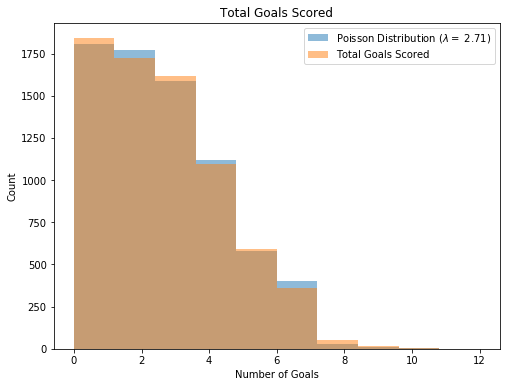

In [26]:
#plot histogram for total goals scored and overlay with poisson distribution
plt.figure(figsize=(8,6))
plt.hist(data_poisson, density =False, alpha=0.5, 
         label=f'Poisson Distribution ($\lambda = $ {round(ft_avg,2)})')
plt.hist(df['Goals_FT'], density = False, alpha=0.5, 
         label="Total Goals Scored")
plt.xlabel('Number of Goals')
plt.ylabel('Count')
plt.title('Total Goals Scored')
plt.legend()
plt.show()

A poisson distribution was chosen to model total number of goals scored in a match. The distribution was chosen since goal scoring is event-based, and a rare occurrence in soccer games. The value of $\lambda$ is the empirical mean of our data, which is 2.71 total goals scored on average during the full time of a game. The value of $k$, which is the number of samples, is set to the size of our data (7304 matches) because it models the number of discrete events.

### Part 2b

In [27]:
#total number of goals scored up to half-time
df.loc[:,'Goals_HT'] = df.loc[:,'HTG_Home']+df.loc[:,'HTG_Away']
ht_avg = df.loc[:,'Goals_HT'].mean()

In [28]:
#generate poisson distribution setting lambda to mean of our data
data_poisson = poisson.rvs(mu=ht_avg,
                           size=len(df['Goals_HT']),random_state = 2021)

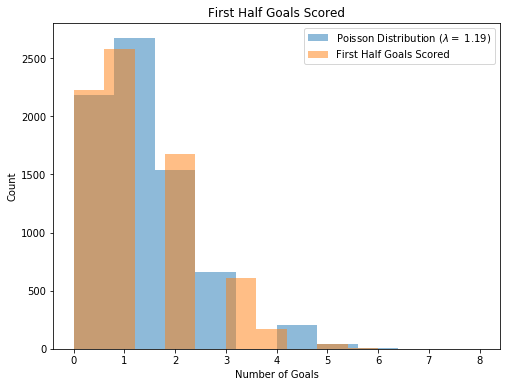

In [29]:
#plot histogram for first half goals scored and overlay with poisson distribution
plt.figure(figsize=(8,6))
plt.hist(data_poisson, density =False, alpha=0.5, 
         label=f'Poisson Distribution ($\lambda = $ {round(ht_avg,2)})')
plt.hist(df['Goals_HT'], density = False, alpha=0.5, 
         label="First Half Goals Scored")
plt.xlabel('Number of Goals')
plt.ylabel('Count')
plt.title('First Half Goals Scored')
plt.legend()
plt.show()

A poisson distribution was chosen to model total number of goals scored in a match. The distribution was chosen since goal scoring is event-based, and a rare occurrence in soccer games. The value of $\lambda$ is the empirical mean of our data, which is 1.19 total goals scored on average during the first half of a game. The value of $k$, which is the number of samples, is set to the size of our data (7304 matches) because it models the number of discrete events.

### Part 2c

In [30]:
#total number of goals scored in second half
df.loc[:,'Goals_SH'] = df.loc[:,'Goals_FT']-df.loc[:,'Goals_HT']
sh_avg = df.loc[:,'Goals_SH'].mean()

In [31]:
#generate poisson distribution setting lambda to mean of our data
data_poisson = poisson.rvs(mu=sh_avg, 
                           size=len(df['Goals_SH']),random_state = 2021)

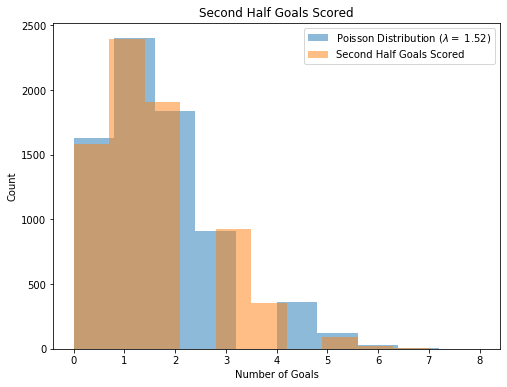

In [32]:
#plot histogram for second half goals scored and overlay with poisson distribution
plt.figure(figsize=(8,6))
plt.hist(data_poisson, density =False, alpha=0.5, 
         label=f'Poisson Distribution ($\lambda = $ {round(sh_avg,2)})')
plt.hist(df['Goals_SH'], density = False, alpha=0.5, 
         label="Second Half Goals Scored")
plt.xlabel('Number of Goals')
plt.ylabel('Count')
plt.title('Second Half Goals Scored')
plt.legend()
plt.show()

A poisson distribution was chosen to model total number of goals scored in a match. The distribution was chosen since goal scoring is event-based, and a rare occurrence in soccer games. The value of $\lambda$ is the empirical mean of our data, which is 1.52 total goals scored on average during the full time of a game. The value of $k$, which is the number of samples, is set to the size of our data (7304 matches) because it models the number of discrete events.

### Part 2d

In [33]:
#group by league
group_league = df.groupby('Div')

In [34]:
#get summary of average number of goals per game by league
league_summary = group_league.agg(
    Goals_avg = pd.NamedAgg(column = 'Goals_FT', aggfunc = 'mean'),
    Num_games = pd.NamedAgg(column = 'Game_ID', aggfunc = 'count')
    )
league_summary = league_summary.sort_values('Goals_avg', 
                                            ascending = False)

In [35]:
league_summary

,Goals_avg,Num_games
Div,,
Bundesliga,2.811275,1224
La_Liga,2.759211,1520
Serie_A,2.725658,1520
EPL,2.686184,1520
Ligue_1,2.588158,1520


### Part 2e

In [36]:
#only analyze games with exactly 4 goals scored
#where home and away teams approx evenly matched
df_highscore = df.loc[(df.Goals_FT ==4) & (abs(df.pH - df.pA)<0.02)]

In [37]:
#function to create indicator column for draws
def draw(df):
    if df.FTG_Home - df.FTG_Away == 0:
        val = 1
    else: 
        val = 0
    return val

In [43]:
#apply draw func to dataframe
df_highscore.loc[:,'Draw'] = df_highscore.apply(draw, axis=1).copy()

In [39]:
#get observed number of draws
observed_draws = df_highscore.loc[:,'Draw'].sum()

In [40]:
#calcualte expected number of draws based on Binomial RV 
#4 goals total with 2 for home, 2 for away
n = 4
k = 2
p = 0.5 #prob of home team scoring
prob_draw = math.factorial(n)/(math.factorial(k)*math.factorial(n-k))*(p)**k*(1-p)**(n-k)

#get expected number of draws
expected_draws = int(len(df_highscore)*prob_draw)

In [41]:
num_games = len(df_highscore)

In [42]:
mean = math.sqrt(num_games*p*(1-p))
stdev = (observed_draws-expected_draws)/mean
stdev

1.9727878476642875

Out of 37 games, we would expect roughly 13 draws, using "null hypothesis". However, we observe 19 draws. The number of draws that occur is much higher than expected, indicating a comeback tendency. This is slightly less than a 2 standard deviation result. However, because only 37 games are included in this analysis, there is not a strong suggestion for comeback tendency because of the few games it is based on, but there is some evidence.